In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## NLP: Disaster Tweets Analysis

### Problem Description: We are trying to predict whether from basic text there exists an actual event. The data itself is largely made up of textual data and contains data which is 5x7613 in size. 

### 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


2024-06-25 17:22:03.816419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 17:22:03.816548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 17:22:03.978803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

### 1. EDA

#### Already we notice that there is some missing data, this could potentially be bad. I mean how do we impute? Or do we just drop? 

In [4]:
print(df.head(2))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   

   target  
0       1  
1       1  


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# Display basic statistics
print(df.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


#### Here we see the size of the problem, on one hand we are missing 2533 values in location which is about 33% of the data. Is location relevant to the model though, I am not convinced of that fact. But we shall see, perhaps it can add value. Same with the keyword column does it add value? 

In [7]:
# Check for missing values
print(df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


### For the time being at least, let us just replace them

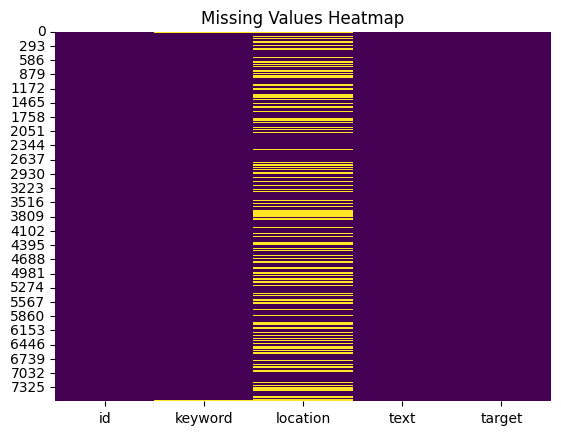

id          0
keyword     0
location    0
text        0
target      0
dtype: int64


In [8]:
# Plot missing values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Fill missing values or drop columns/rows
df.fillna({'keyword':''}, inplace=True)
df.fillna({'location':'Unknown'}, inplace=True)

# Verify missing values are handled
print(df.isnull().sum())


### We do have some sort of close split between Yes and No

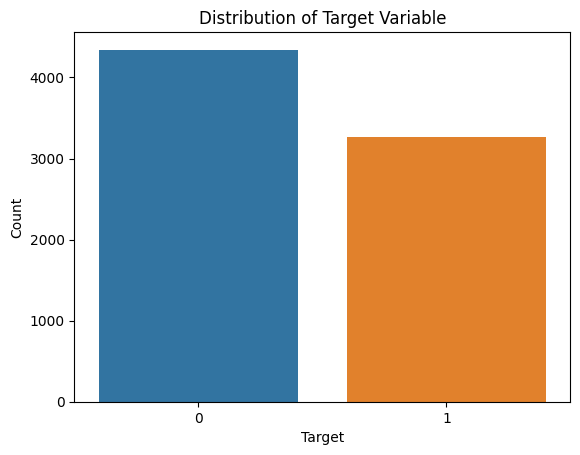

In [9]:
# Plot the distribution of the target variable
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


### Does the length of the tweet play a part in the predictions here? Perhaps this can be made into a feature later on if the model that I build is poor. 

### The histogram gives us an understanding of the general length of the tweets. 

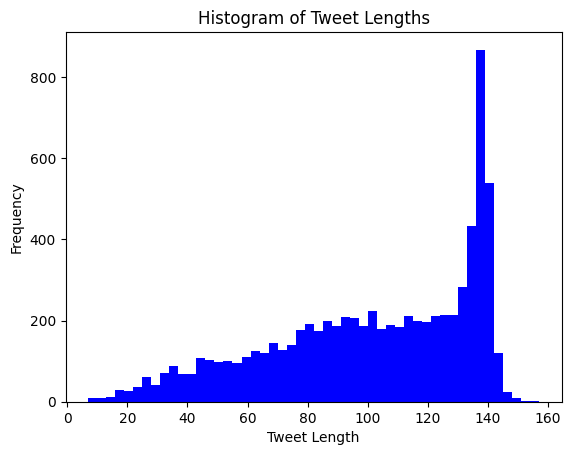

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64


In [10]:
# Calculate tweet lengths
df['text_length'] = df['text'].apply(len)

# Plot histogram of tweet lengths
plt.hist(df['text_length'], bins=50, color='blue')
plt.title('Histogram of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics of tweet lengths
print(df['text_length'].describe())


### Our Wordcloud gives an understanding of the top words used. Some stand out and some do not. Common words in the English language like 'The' are expected to feature strongly, but it appears at least that it does not below. 

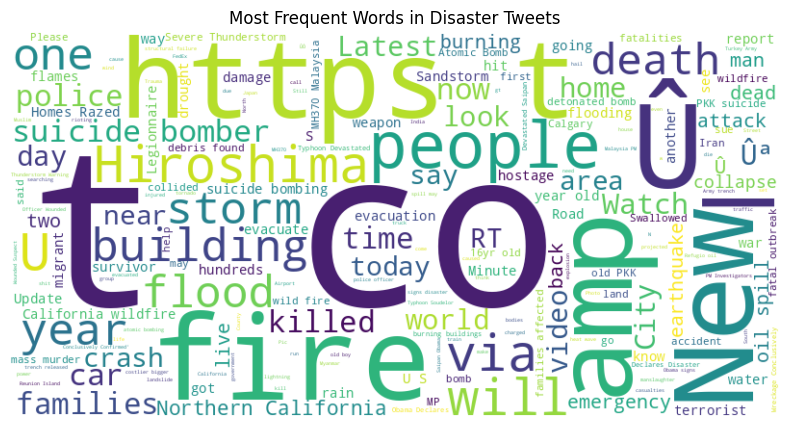

In [11]:
from wordcloud import WordCloud

# Join all text in disaster tweets
disaster_tweets = " ".join(df[df['target'] == 1]['text'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_tweets)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Disaster Tweets')
plt.show()


### The frequency Analysis of the text should provide us with an even better understanding of the spread of words, and either point us in some direction with regards to the tweets.

### We can see there are a fair amount of blanks here or empty text

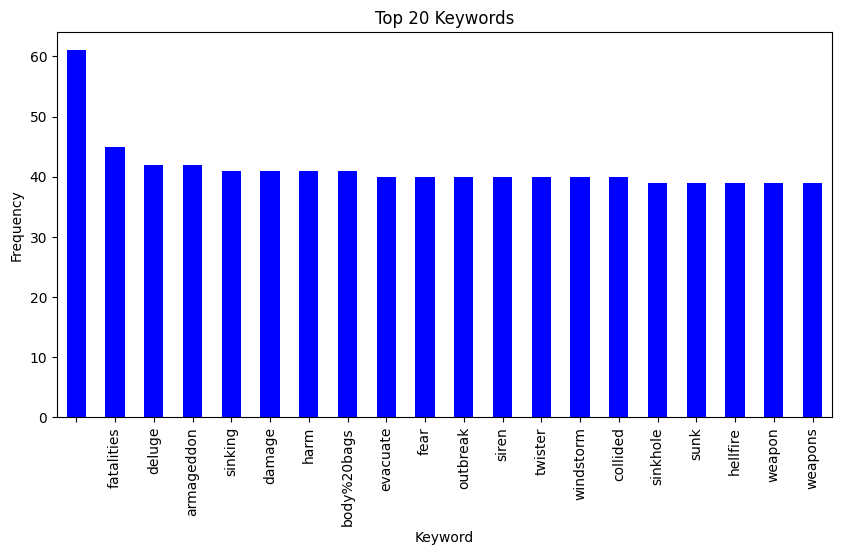

In [12]:
# Count the frequency of keywords
keyword_counts = df['keyword'].value_counts()

# Plot the top 20 keywords
plt.figure(figsize=(10, 5))
keyword_counts[:20].plot(kind='bar', color='blue')
plt.title('Top 20 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()


## 2. Model

### I think first from the above we have to at least clean this, there are too many random things going on here

In [13]:
# Function to clean the text data
def clean_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

# Apply the clean_text function to the text column
df['text'] = df['text'].apply(clean_text)

# Display the cleaned text
df['text'].head()


0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

## 2.1 First Model
### Let's split the data into train and validation from the test set

In [14]:
X = df['text']
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Our Old Friend TFID is used here to provide the conversion into numericals

In [15]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)


#### Let us discuss the initial model: The choice I initially went with is the trusty Logistic Model at first. One of the main reasons for this is that we have simple variable to predict (a 1 or 0 output) AND that the input variables to predict on have just been vectorized using TFID. If this was a bit more complex, then I would have chosen a different model to start with.

In [16]:
# Train the model
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred = log_reg.predict(X_val_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy: 0.8108995403808273
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.83      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix:
 [[781  93]
 [195 454]]


### Well the model performs quite well here. Looking at the accuracy and F1 scores, we seem to be on the right track. Our next steps should be to either refine this model or use one of the class models to see what can come of that as well

## 2.2 New model, let us try as the project brief states, any of the CNN family, using LSTM here. 

#### The architecture of the LSTM is as follows: 
* the input is limited
* create a bidirectional lstm to go from left to right and right to left, to make sure we do not miss anything
* Dropout to prevent overfitting
* Dense layer to aid in predicting an answer

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.6515 - loss: 0.6214 - val_accuracy: 0.8129 - val_loss: 0.4454
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8800 - loss: 0.3133 - val_accuracy: 0.7846 - val_loss: 0.4593
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9271 - loss: 0.2205 - val_accuracy: 0.7840 - val_loss: 0.5032
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9544 - loss: 0.1392 - val_accuracy: 0.7827 - val_loss: 0.5918
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.9660 - loss: 0.1055 - val_accuracy: 0.7768 - val_loss: 0.7264


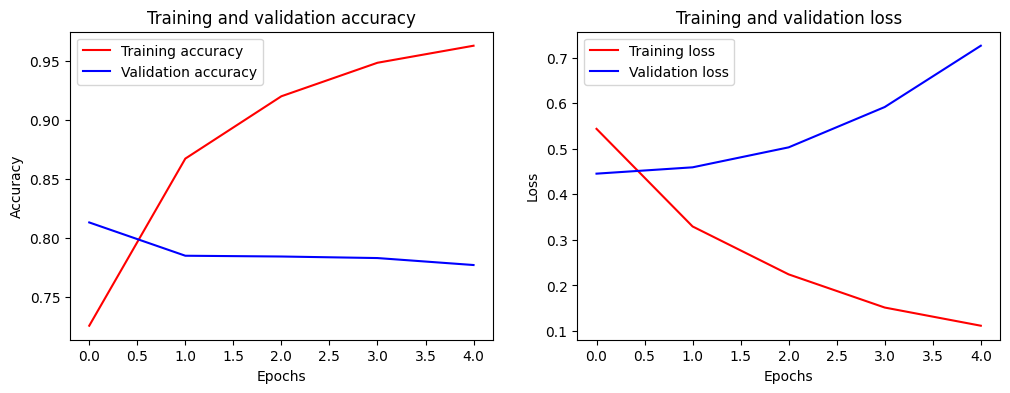

In [17]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

maxlen = 100

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=maxlen)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val))

# Plotting the training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plotting function
plot_training_history(history)


In [18]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [19]:
# Handle missing values in the test dataset
test_df.fillna({'keyword':''}, inplace=True)
test_df.fillna({'location':'Unknown'}, inplace=True)

In [20]:
# Clean the text data
test_df['text'] = test_df['text'].apply(clean_text)

# Tokenize the text
test_seq = tokenizer.texts_to_sequences(test_df['text'])
test_pad = pad_sequences(test_seq, padding='post', maxlen=maxlen)

In [21]:
# Load the trained LSTM model
#best_model = tf.keras.models.load_model('best_disaster_model.h5')

# Predict on the test data
test_predictions = model.predict(test_pad)

# Convert predictions to binary labels (0 or 1)
test_labels = (test_predictions > 0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


In [22]:
# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_labels.ravel()
})

In [23]:
# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(submission_df.head())

   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1


## 2.2.1 Result of second model
### So our first submission resulted in a 0.76 score. That is pretty good for a first try, can we better it? 

### Hyper-Parameter Tuning

In [24]:
# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=128, step=32), input_length=maxlen))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units_2', min_value=16, max_value=64, step=16))))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
from keras_tuner.tuners import RandomSearch
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter settings to try
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='disaster_tweets'
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Define the batch size
batch_size = 32

# Define the number of epochs
epochs = 5

# Start the hyperparameter search
tuner.search(X_train_pad, y_train, epochs=epochs, validation_data=(X_val_pad, y_val), batch_size=batch_size)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
val_loss, val_accuracy = best_model.evaluate(X_val_pad, y_val)
print(f'Best Model Validation Accuracy: {val_accuracy}')

# Save the best model
best_model.save('best_disaster_model.h5')

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8019 - loss: 0.4536
Best Model Validation Accuracy: 0.813525915145874


In [31]:
# Load the trained LSTM model
best_model = tf.keras.models.load_model('best_disaster_model.h5')

# Predict on the test data
test_predictions = best_model.predict(test_pad)

# Convert predictions to binary labels (0 or 1)
test_labels = (test_predictions > 0.5).astype(int)

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_labels.ravel()
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step
   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1


### This tuned model achieves a score of 0.79

## 3. Discussion

### One of the things that is noticed is that the LSTM model does handle the data a fair amount better than the regression model. It is better equipped to do so in terms of the parameters and model build up available to it.

### There was a marked improvement from the first model to the tuned model around 3%, which is great. We could definitely tweak the parameters and be a bit more agressive in some areas such as choosing a wider range of values for the LSTM layers. The tradeoff here is that the algorithm will be slow to run (this notebook timed out whilst I was tuning it, and I had to then limit the parameter ranges). 

### The further improvements that can be made is to a few more up front filtering steps, maybe even inferring data from the other columns to see if that could also help. 

### All in all a great start to understanding the new model. 